In [1]:
import pandas as pd
import numpy as np
from gensim import corpora
from tqdm import tqdm
import matplotlib.pyplot as plt

## Step 1. Downloading dataset
- Original link from Kaggle: https://www.kaggle.com/hwassner/TwitterFriends
- We uploaded the original file on Kaggle to Google Drive to guarantee the access to our dataset: https://drive.google.com/file/d/13BLIS_eQTdz6XsHkERQYDAI3vWtDMM-p/view?usp=share_link 

In [2]:
df = pd.read_json('data_twitter.json')
df.head(2)
print(df.shape)

(40002, 10)


In [3]:
# delete empty friends list
total = 0
leng = [] 
leng_high0 = []

friends = df['friends']
userid_40002 = [str(i) for i in df['id']]
for i in range(len(df)):
    length = len(friends[i])
    total += length
    leng.append(length)
    
leng_0_id = []
for i, x in enumerate(leng):
    if x == 0:
        leng_0_id.append(i)
    else:
        leng_high0.append(x)
        
print(len(leng_0_id))
df = df.drop(labels = leng_0_id, axis=0)
df.index = range(len(df))
friends = df['friends']

87


## Step 2. Pre-processing

In [4]:
# identify id whose following lists is empty
id_length_0 = []     
for i in range(len(df)):
    length = len(df['friends'][i])
    if length == 0:
        id_length_0.append(i)
    else:
        pass
print('number of empty following lists in this dataset:', len(id_length_0))

# delete empty following list
df = df.drop(labels = id_length_0, axis=0)
df.index = range(len(df))

# following_lists: 
f_lists = df['friends']
print(f_lists.head(5))

number of empty following lists in this dataset: 0
0    [1969574754, 1969295556, 1969284056, 196961221...
1    [60789485, 2420931980, 2899776756, 127410795, ...
2    [361335082, 1405248468, 24626354, 725675895965...
3    [1571896093, 768938323612008448, 2548665930, 3...
4    [2432417994, 752203567382093824, 7421603779164...
Name: friends, dtype: object


In [5]:
# original dictionary (i.e., GENSIM object that consists of the collection of unique followee IDs) in our dataset; 
dictionary = corpora.Dictionary(f_lists, prune_at = 50000000) 

# filter less popular items and extremely short lists in our dataset (frequency < 5)
dictionary.filter_extremes(no_below = 5, keep_n = 50000000)
Iu = [dictionary.doc2idx(user) for user in f_lists]
Iu_new = []
for u_list in tqdm(Iu):
    if len(u_list) > 10:
        u_list_new = []
        for j in u_list:
            if j != -1:   # this item is not niche (i.e., the corpora frequency of this item is larger than 5)
                u_list_new.append(j)
            else:
                pass
        if len(u_list_new) > 10:
            str_u_list_new = [str(i) for i in u_list_new]
            Iu_new.append(str_u_list_new)
        else:
            pass
    else:
        pass
    
# identify and filter out items with error (i.e., subsequent followees are the same) 
u_lists = []
for u_list in Iu_new:
    u_list_new = []
    for j in range(len(u_list)):
        if j > 0:
            i1 = u_list[j]
            i2 = u_list[j-1]
            if i1 == i2:
                print('delete user', i, "'s ", j, "-th item")
            else:    
                u_list_new.append(i1)
        else:
            u_list_new.append(u_list[0])
    u_lists.append(u_list_new)
    
# dataset after processing:
dictionary = corpora.Dictionary(u_lists, prune_at = 50000000)
Iu_new = [dictionary.doc2idx(user) for user in u_lists]
print('Number of users that contributed their following sequences:', len(u_lists))
print('Number of unique followees in our repository:', len(dictionary))
print('Sum of followees in our repository of following sequences:', np.sum([len(i) for i in u_lists]))

100%|██████████| 39915/39915 [00:10<00:00, 3840.34it/s]


delete user 39914 's  3610 -th item
delete user 39914 's  3668 -th item
delete user 39914 's  2282 -th item
Number of users that contributed their following sequences: 39564
Number of unique followees in our repository: 912150
Sum of followees in our repository of following sequences: 16821242


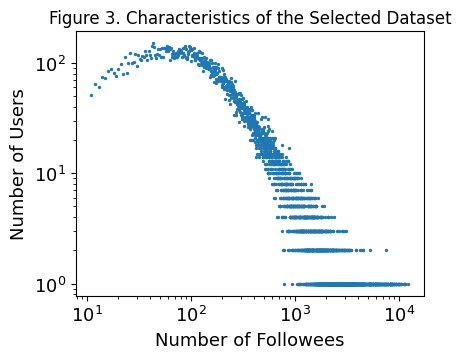

In [6]:
# Characteristics of the Selected Dataset
# X: number of followees
# Y: number of users

u_length = [len(u) for u in Iu_new]
df_length = pd.DataFrame({'length': u_length})
df_dict = df_length.length.value_counts().to_dict()

# Plot
# plt.figure()
plt.figure(figsize=(4.5, 3.5), dpi=100)
plt.scatter(list(df_dict.keys()), list(df_dict.values()), s=2)  # , bins = 500, histtype='step'
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13)
plt.title('Figure 3. Characteristics of the Selected Dataset')
plt.xlabel('Number of Followees', fontsize=13)
plt.ylabel('Number of Users', fontsize=13)
plt.show()

## Step 3. Constructing cross-validation datasets

In [7]:
df_folds = pd.DataFrame({'f_lists': Iu_new, 'length': u_length})
df_folds.head(3)

,f_lists,length
0,"[4, 16, 5, 6, 1, 3, 10, 11, 13, 9, 20, 8, 7, 0...",21
1,"[52, 117, 22, 86, 69, 159, 76, 56, 90, 99, 115...",160
2,"[180, 188, 202, 233, 241, 184, 207, 215, 224, ...",73


In [8]:
# reverse chronological sequence
r_f_list = []
for i in tqdm(range(len(df_folds))): 
    f_list = df_folds['f_lists'][i]
    r_f_list.append(f_list.reverse())

100%|██████████| 39564/39564 [00:00<00:00, 145665.75it/s]


In [9]:
# Now, f_lists have already been reversed
df_folds.head(2)

,f_lists,length
0,"[18, 12, 19, 2, 14, 15, 17, 0, 7, 8, 20, 9, 13...",21
1,"[37, 146, 132, 67, 135, 85, 177, 170, 83, 172,...",160


In [10]:
# five folds dataset
Fold1 = []
Fold2 = []
Fold3 = []
Fold4 = []
Fold5 = []

N = 9   # 5%9
for i in range(len(df_folds)):
    fold = df_folds['length'][i] / N
    u_list = df_folds['f_lists'][i]
    Fold1.append(u_list[int(0*fold):int((N-4)*fold)])
    Fold2.append(u_list[int(1*fold):int((N-3)*fold)])
    Fold3.append(u_list[int(2*fold):int((N-2)*fold)])
    Fold4.append(u_list[int(3*fold):int((N-1)*fold)])
    Fold5.append(u_list[int(4*fold):int((N-0)*fold)])
df_folds['Fold1'] = Fold1
df_folds['Fold2'] = Fold2
df_folds['Fold3'] = Fold3
df_folds['Fold4'] = Fold4
df_folds['Fold5'] = Fold5
df_folds.head(3)

,f_lists,length,Fold1,Fold2,Fold3,Fold4,Fold5
0,"[18, 12, 19, 2, 14, 15, 17, 0, 7, 8, 20, 9, 13...",21,"[18, 12, 19, 2, 14, 15, 17, 0, 7, 8, 20]","[19, 2, 14, 15, 17, 0, 7, 8, 20, 9, 13, 11]","[14, 15, 17, 0, 7, 8, 20, 9, 13, 11, 10, 3]","[0, 7, 8, 20, 9, 13, 11, 10, 3, 1, 6]","[8, 20, 9, 13, 11, 10, 3, 1, 6, 5, 16, 4]"
1,"[37, 146, 132, 67, 135, 85, 177, 170, 83, 172,...",160,"[37, 146, 132, 67, 135, 85, 177, 170, 83, 172,...","[101, 155, 47, 91, 113, 27, 31, 137, 58, 151, ...","[78, 139, 171, 162, 40, 36, 82, 145, 24, 178, ...","[81, 93, 34, 73, 174, 53, 74, 77, 72, 33, 121,...","[169, 118, 168, 106, 23, 32, 173, 26, 65, 63, ..."
2,"[219, 226, 221, 198, 212, 208, 237, 243, 216, ...",73,"[219, 226, 221, 198, 212, 208, 237, 243, 216, ...","[216, 242, 201, 235, 186, 204, 244, 181, 182, ...","[182, 187, 211, 213, 231, 205, 230, 196, 200, ...","[200, 194, 185, 227, 217, 236, 251, 245, 214, ...","[214, 225, 220, 191, 222, 183, 195, 240, 247, ..."


In [11]:
# draw 99 negative samples that never been followed by this user
def draw_negative(global_train_test, N=99):
    negative_sample = []
    w = 0
    while w < N:
        item_id = np.random.randint(912150)   # 912150: len(dictionary)
        if item_id in global_train_test:
            pass
        else:
            negative_sample.append(item_id)
            w += 1
    return negative_sample

def update_neg_samples(groups):    
    Fold1_train = []
    Fold1_test = []
    Fold2_train = []
    Fold2_test = []
    Fold3_train = []
    Fold3_test = []
    Fold4_train = []
    Fold4_test = []
    Fold5_train = []
    Fold5_test = []
    
    print(' //// Processing Fold 1')
    Fold = Fold1
    for i in range(len(groups)):
        global_train_test = groups['f_lists'][i]
        # 5%9
        fold = Fold[i]
        cutpoint = len(fold)-1
        batch_train = fold[: cutpoint]
        batch_test = fold[cutpoint: ]
        # negative samples
        negative_sample = draw_negative(global_train_test, N=99)   # update negative samples
        Fold1_train.append(batch_train)
        Fold1_test.append(batch_test+negative_sample)
    
    print(' //// Processing Fold 2')
    Fold = Fold2
    for i in range(len(groups)):
        global_train_test = groups['f_lists'][i]
        fold = Fold[i]
        cutpoint = len(fold)-1
        batch_train = fold[: cutpoint]
        batch_test = fold[cutpoint: ]
        # negative samples
        negative_sample = draw_negative(global_train_test, N=99)   # update negative samples
        Fold2_train.append(batch_train)
        Fold2_test.append(batch_test+negative_sample)
        
    print(' //// Processing Fold 3')    
    Fold = Fold3
    for i in range(len(groups)):
        global_train_test = groups['f_lists'][i]
        fold = Fold[i]
        cutpoint = len(fold)-1
        batch_train = fold[: cutpoint]
        batch_test = fold[cutpoint: ]
        # negative samples
        negative_sample = draw_negative(global_train_test, N=99)   # update negative samples
        Fold3_train.append(batch_train)
        Fold3_test.append(batch_test+negative_sample)
        
    print(' //// Processing Fold 4')
    Fold = Fold4
    for i in range(len(groups)):
        global_train_test = groups['f_lists'][i]
        fold = Fold[i]
        cutpoint = len(fold)-1
        batch_train = fold[: cutpoint]
        batch_test = fold[cutpoint: ]
        # negative samples
        negative_sample = draw_negative(global_train_test, N=99)   # update negative samples
        Fold4_train.append(batch_train)
        Fold4_test.append(batch_test+negative_sample)
        
    print(' //// Processing Fold 5')
    Fold = Fold5
    for i in range(len(groups)):
        global_train_test = groups['f_lists'][i]
        fold = Fold[i]
        cutpoint = len(fold)-1
        batch_train = fold[: cutpoint]
        batch_test = fold[cutpoint: ]
        # negative samples
        negative_sample = draw_negative(global_train_test, N=99)   # update negative samples
        Fold5_train.append(batch_train)
        Fold5_test.append(batch_test+negative_sample)
    
    # save
    df = pd.DataFrame({
        'Fold1_train': Fold1_train, 'Fold1_test': Fold1_test, 'Fold2_train': Fold2_train, 'Fold2_test': Fold2_test, 
        'Fold3_train': Fold3_train, 'Fold3_test': Fold3_test, 'Fold4_train': Fold4_train, 'Fold4_test': Fold4_test, 
        'Fold5_train': Fold5_train, 'Fold5_test': Fold5_test
    })
    return df

# processing
df = update_neg_samples(df_folds)
df.head(2)

 //// Processing Fold 1
 //// Processing Fold 2
 //// Processing Fold 3
 //// Processing Fold 4
 //// Processing Fold 5


,Fold1_train,Fold1_test,Fold2_train,Fold2_test,Fold3_train,Fold3_test,Fold4_train,Fold4_test,Fold5_train,Fold5_test
0,"[18, 12, 19, 2, 14, 15, 17, 0, 7, 8]","[20, 466442, 491038, 75100, 69732, 56581, 5442...","[19, 2, 14, 15, 17, 0, 7, 8, 20, 9, 13]","[11, 766258, 185282, 731026, 232180, 326261, 2...","[14, 15, 17, 0, 7, 8, 20, 9, 13, 11, 10]","[3, 533834, 152278, 534098, 623980, 653692, 33...","[0, 7, 8, 20, 9, 13, 11, 10, 3, 1]","[6, 400546, 552378, 610911, 593462, 269952, 51...","[8, 20, 9, 13, 11, 10, 3, 1, 6, 5, 16]","[4, 266331, 80222, 114201, 455320, 491472, 486..."
1,"[37, 146, 132, 67, 135, 85, 177, 170, 83, 172,...","[28, 855120, 352900, 372555, 44376, 484331, 21...","[101, 155, 47, 91, 113, 27, 31, 137, 58, 151, ...","[54, 466072, 456300, 657762, 827644, 658138, 5...","[78, 139, 171, 162, 40, 36, 82, 145, 24, 178, ...","[116, 293784, 543814, 887471, 109818, 304884, ...","[81, 93, 34, 73, 174, 53, 74, 77, 72, 33, 121,...","[136, 652513, 107960, 225641, 302059, 216971, ...","[169, 118, 168, 106, 23, 32, 173, 26, 65, 63, ...","[52, 343360, 549235, 185922, 476843, 342488, 3..."


## Step 4. Constructing Training Sets and Test Sets for PE-LDA in C (optional)

In [12]:
g = 1
# df_train dataset
for n in range(1, 6):
    train = df['Fold'+str(n)+'_train']
    # C style dataframe:  
    user_id = []
    item_id = []
    for u in tqdm(range(len(train))):
        u_list = train[u]
        for j in range(len(u_list)):
            user_id.append(u)
            item_id.append(u_list[j])
    df_train = pd.DataFrame({'id': range(len(item_id)), 'user_id': user_id, 'item_id': item_id})
    # save:
    df_train.to_csv('CV_5%9_group'+str(g)+'_Fold'+str(n)+'_Train.csv', sep=',', index=False)

100%|██████████| 39564/39564 [00:02<00:00, 14207.20it/s]


In [13]:
# construct 5 groups of negative samples 
for g in range(5):         
    df = update_neg_samples(df_folds)
    for n in range(1, 6): 
        test =  df['Fold'+str(n)+'_test']
        # C style dataframe: 
        user_id = []
        item_id = []
        for u in tqdm(range(len(test))):
            u_list = test[u]
            for j in range(len(u_list)):
                user_id.append(u)
                item_id.append(u_list[j])
        # save:
        df_test = pd.DataFrame({'id': range(len(item_id)), 'user_id': user_id, 'item_id': item_id})
        df_test.reset_index(drop=True)
        df_test.to_csv('CV_5%9_group'+str(g)+'_Fold'+str(n)+'_Groundtruth+99.csv', sep=',', index=False)

 //// Processing Fold 1
 //// Processing Fold 2
 //// Processing Fold 3
 //// Processing Fold 4
 //// Processing Fold 5


100%|██████████| 39564/39564 [00:01<00:00, 37985.62it/s]


 //// Processing Fold 1
 //// Processing Fold 2
 //// Processing Fold 3
 //// Processing Fold 4
 //// Processing Fold 5


100%|██████████| 39564/39564 [00:00<00:00, 40087.14it/s]


 //// Processing Fold 1
 //// Processing Fold 2
 //// Processing Fold 3
 //// Processing Fold 4
 //// Processing Fold 5


100%|██████████| 39564/39564 [00:00<00:00, 41040.42it/s]


 //// Processing Fold 1
 //// Processing Fold 2
 //// Processing Fold 3
 //// Processing Fold 4
 //// Processing Fold 5


100%|██████████| 39564/39564 [00:01<00:00, 37132.94it/s]


 //// Processing Fold 1
 //// Processing Fold 2
 //// Processing Fold 3
 //// Processing Fold 4
 //// Processing Fold 5


100%|██████████| 39564/39564 [00:01<00:00, 36945.39it/s]


## Step 5. Constructing Training Sets and Test Sets for PE-LDA in Python

In [15]:
# train set
train1 = pd.read_csv('CV_5%9_Fold1_Train.csv')
train2 = pd.read_csv('CV_5%9_Fold2_Train.csv')
train3 = pd.read_csv('CV_5%9_Fold3_Train.csv')
train4 = pd.read_csv('CV_5%9_Fold4_Train.csv')
train5 = pd.read_csv('CV_5%9_Fold5_Train.csv')

u_id = []
u_train1 = []
for i in tqdm(train1.groupby(['user_id'])):
    uid = i[0]
    u_id.append(uid)
    u_train1.append(list(i[1]['item_id']))

u_train2 = []
for i in tqdm(train2.groupby(['user_id'])):
    uid = i[0]
    u_train2.append(list(i[1]['item_id']))

u_train3 = []
for i in tqdm(train3.groupby(['user_id'])):
    uid = i[0]
    u_train3.append(list(i[1]['item_id']))

u_train4 = []
for i in tqdm(train4.groupby(['user_id'])):
    uid = i[0]
    u_train4.append(list(i[1]['item_id']))

u_train5 = []
for i in tqdm(train5.groupby(['user_id'])):
    uid = i[0]
    u_train5.append(list(i[1]['item_id']))

# test set
test1 = pd.read_csv('CV_5%9_group3_Fold1_Groundtruth+99.csv')
test2 = pd.read_csv('CV_5%9_group3_Fold2_Groundtruth+99.csv')
test3 = pd.read_csv('CV_5%9_group3_Fold3_Groundtruth+99.csv')
test4 = pd.read_csv('CV_5%9_group3_Fold4_Groundtruth+99.csv')
test5 = pd.read_csv('CV_5%9_group3_Fold5_Groundtruth+99.csv')

u_id = []
u_test1 = []
for i in tqdm(test1.groupby(['user_id'])):
    uid = i[0]
    u_id.append(uid)
    u_test1.append(list(i[1]['item_id']))

u_test2 = []
for i in tqdm(test2.groupby(['user_id'])):
    uid = i[0]
    u_test2.append(list(i[1]['item_id']))

u_test3 = []
for i in tqdm(test3.groupby(['user_id'])):
    uid = i[0]
    u_test3.append(list(i[1]['item_id']))

u_test4 = []
for i in tqdm(test4.groupby(['user_id'])):
    uid = i[0]
    u_test4.append(list(i[1]['item_id']))

u_test5 = []
for i in tqdm(test5.groupby(['user_id'])):
    uid = i[0]
    u_test5.append(list(i[1]['item_id']))
    
df = pd.DataFrame({
    'u_id': u_id, 'Fold1_train': u_train1, 'Fold2_train': u_train2, 'Fold3_train': u_train3, 
    'Fold4_train': u_train4, 'Fold5_train': u_train5, 'Fold1_test': u_test1, 'Fold2_test': u_test2, 
    'Fold3_test': u_test3, 'Fold4_test': u_test4, 'Fold5_test': u_test5})
df.to_json('CrossValidation_5%9_group3_Leave1Out+99NegSamples.json')

100%|██████████| 39564/39564 [00:03<00:00, 11880.72it/s]
